In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import random
import matplotlib.pyplot as plt

this PyTorch CNN Classification model predict chinese number characters. 
```
{
  0: "十",
  1: "一",
  2: "二",
  3: "三",
  4: "四",
  5: "五",
  6: "六",
  7: "七",
  8: "八",
  9: "九",
}
```


In [3]:
class MNIST_CH_Dataset(torch.utils.data.Dataset):
    def __init__(self,img_dir,images,transforms=None):
        self.img_dir = img_dir
        self.inputs = images
        self.transforms = transforms
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.inputs[idx])
        input = torchvision.io.read_image(img_path)
        if self.transforms:
            input = self.transforms(input)
        target =torch.tensor(int(self.inputs[idx].split('.')[-2][-1] ))
        return input,target

torch.Size([1, 32, 32])


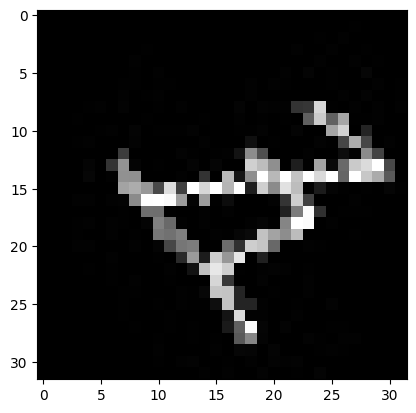

In [14]:
transform_train = transforms.Compose([
                                      transforms.RandomRotation(60),
                                      transforms.RandomCrop(32),
                                      # transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomAffine(0, translate=(0.1, 0.1)),
                                      transforms.ConvertImageDtype(dtype=torch.float32),
                                      ])

imagePath = os.path.join(os.getcwd()+"/MNIST-CH", "chinese_numbers_v3_0000s_0004_5.jpg")
torchvisionImage = torchvision.io.read_image(imagePath)
t_image = transform_train(torchvisionImage)

print(t_image.shape)
hisInput = torch.flatten(t_image)
np_image = hisInput.numpy()
plt.imshow(t_image[0],cmap='gray')

In [16]:
images = []
testImages =[]

totalImages = os.listdir( os.getcwd()+"/MNIST-CH")

for index in range(len(totalImages)):
    image = totalImages[index]
    if image.endswith(".jpg"):
        if index <= 100:
            images.append(image)
        else:
            testImages.append(image)

In [17]:
train_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=images, transforms=transform_train )
test_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=testImages, transforms=transform_train )
    
           
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)


In [23]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128*3*3, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10)   
)

# 32 x 32
# ((32-3) + 1) / 2  = 15x15
# ((15-3) + 1) / 2  = 7x7
# ((7-3) + 1) / 2  = 3x3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
 

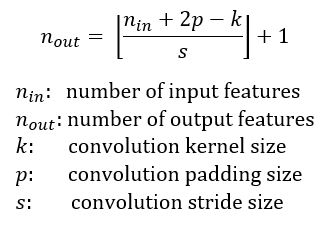

In [24]:
n_epochs = 200
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_dataloader:

    optimizer.zero_grad()
    outputs = model(inputs)
  
    loss = criterion(outputs, targets)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    
    test_loss = []
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

  train_loss = np.mean(train_loss) # a little misleading
  train_losses[it] = train_loss
  test_losses[it] = test_loss
  if (it + 1) % 20 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
  if it == 0:
    print(inputs.shape)

torch.Size([10, 1, 32, 32])
Epoch 20/200, Train Loss: 1.1608, Test Loss: 1.8821
Epoch 40/200, Train Loss: 0.9247, Test Loss: 0.8141
Epoch 60/200, Train Loss: 0.6117, Test Loss: 0.4381
Epoch 80/200, Train Loss: 0.3746, Test Loss: 0.1665
Epoch 100/200, Train Loss: 0.2843, Test Loss: 1.1578
Epoch 120/200, Train Loss: 0.2979, Test Loss: 0.5133
Epoch 140/200, Train Loss: 0.2759, Test Loss: 0.9242
Epoch 160/200, Train Loss: 0.1362, Test Loss: 0.2686
Epoch 180/200, Train Loss: 0.1253, Test Loss: 0.1790
Epoch 200/200, Train Loss: 0.0988, Test Loss: 0.5580


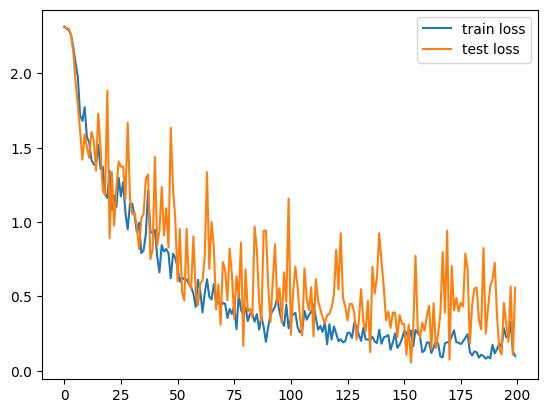

In [25]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [26]:
# accuracy
model.eval()

n_correct = 0.
n_total = 0.
for inputs, targets in train_dataloader:
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_dataloader:
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9900, Test acc: 0.9000


Result: 5


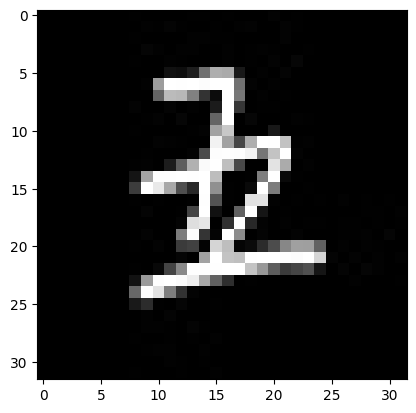

In [29]:
model.eval()
torch.set_printoptions(linewidth=200)

index = random.randrange(20)
test_image_path = os.path.join(os.getcwd()+"/MNIST-CH", testImages[index])

result_Image = torchvision.io.read_image(test_image_path)
result_input = transform_train(result_Image)    
result_input = result_input[None,:, :, :]

output = model(result_input)

_, predictions = torch.max(output, 1)
result = predictions.item()

print(f"Result: {result}")
plt.imshow(result_Image[0],cmap='gray')